In [16]:
%pip install pillow
%pip install numpy
%pip install scipy
%pip install opencv-python

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal, ndimage
import ncc

In [249]:
def MakeGaussianPyramid(arr: np.ndarray, scale: float = 0.75, minsize: float = 200) -> list[np.ndarray]:
    arr = arr.astype(np.float32)
    pyramid = [arr] 
    while max(arr.shape) >= minsize: 
        arr = ndimage.gaussian_filter(arr, sigma=1/(2*scale))
        img = Image.fromarray(arr)
        img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), Image.BICUBIC)
        arr = np.asarray(img).astype(np.float32)
        pyramid.append(np.asarray(arr).astype(np.float32))
    return pyramid
pyramid = MakeGaussianPyramid(np.asarray(Image.open('faces/judybats.jpg')))
# for img in pyramid: 
#     display(Image.fromarray(img.astype(np.uint8)))

C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1231856965.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), Image.BICUBIC)


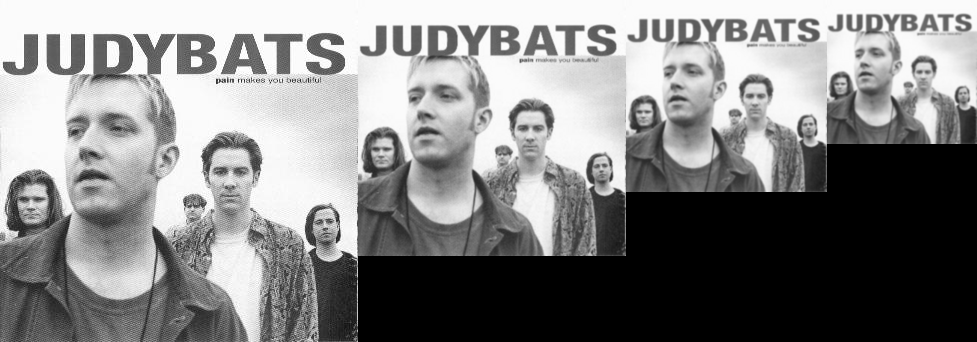

In [251]:
def ShowGaussianPyramid(pyramid: list[np.ndarray]) -> None: 
    width = 0
    height = 0
    for arr in pyramid: 
        img = Image.fromarray(arr.astype(np.uint8))
        width += img.size[0]
        height = max(height, img.size[1])
    result = Image.new('RGB', (width, height))
    x = 0
    for arr in pyramid: 
        img = Image.fromarray(arr.astype(np.uint8))
        result.paste(img, (x, 0))
        x += img.size[0]
    display(result)
ShowGaussianPyramid(pyramid)

In [252]:
def findTemplate(pyramid: list[np.ndarray], template: np.ndarray): 
    original_template_size = template.shape
    # display(Image.fromarray(template.astype(np.uint8)))
    # print(template.shape)
    resize_ratio = 15/template.shape[1]
    template = Image.fromarray(template.astype(np.uint8)).resize((int(template.shape[1]*resize_ratio), int(template.shape[0]*resize_ratio)), Image.BICUBIC)
    # display(template)
    # print(template.size)
    output = Image.fromarray(pyramid[0].astype(np.uint8)).convert('RGB')
    draw = ImageDraw.Draw(output)
    for img_index in range(len(pyramid)): 
        img = Image.fromarray(pyramid[img_index].astype(np.uint8))
        corr = ncc.normxcorr2D(img, template)        
        img = img.convert('RGB')
        stage_draw = ImageDraw.Draw(img)
        # display(img)
        # display(template)
        # display(Image.fromarray((np.maximum(corr, 0) * 255).astype(np.uint8)))
        for i in range(corr.shape[0]):
            for j in range(corr.shape[1]):
                if corr[i][j] > 0.57:
                    draw.rectangle((j/0.75**(img_index) - template.size[0]/2/0.75**(img_index), i/0.75**(img_index) - template.size[1]/2/0.75**(img_index), j/0.75**(img_index) + template.size[0]/2/0.75**(img_index), i/0.75**(img_index) + template.size[1]/2/0.75**(img_index)), outline='red', width=2)
                    stage_draw.rectangle((j - original_template_size[1]/2, i - original_template_size[0]/2, j + original_template_size[1]/2, i + original_template_size[0]/2), outline='red', width=2)
        # display(img)
    display(output)

C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1231856965.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), Image.BICUBIC)
C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\666239691.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  template = Image.fromarray(template.astype(np.uint8)).resize((int(template.shape[1]*resize_ratio), int(template.shape[0]*resize_ratio)), Image.BICUBIC)
c:\Users\kerry\Downloads\CPSC425\assignment2\ncc.py:59: RuntimeWarning: divide by zero encountered in divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


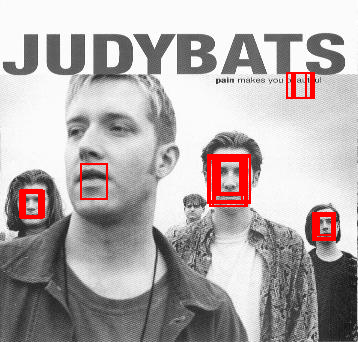

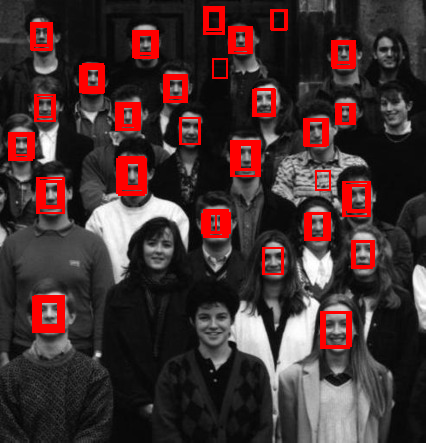

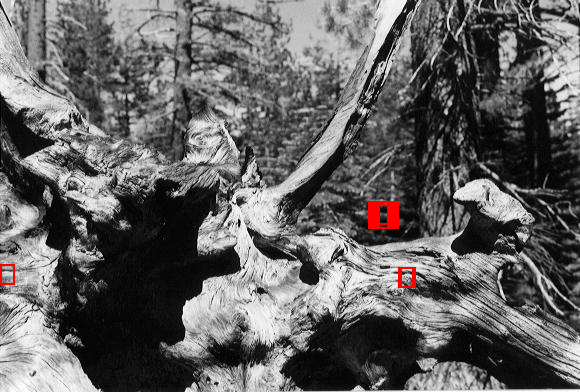

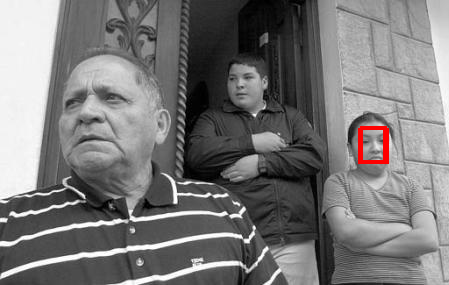

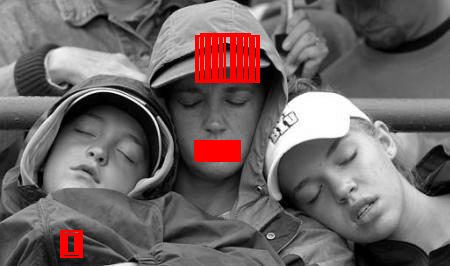

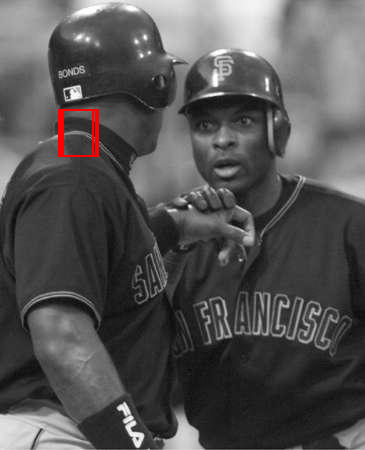

In [253]:
findTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/judybats.jpg').convert('L'))), np.asarray(Image.open('faces/template.jpg').convert('L')))
findTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/students.jpg').convert('L'))), np.asarray(Image.open('faces/template.jpg').convert('L')))
findTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/tree.jpg').convert('L'))), np.asarray(Image.open('faces/template.jpg').convert('L')))
findTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/family.jpg').convert('L'))), np.asarray(Image.open('faces/template.jpg').convert('L')))
findTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/fans.jpg').convert('L'))), np.asarray(Image.open('faces/template.jpg').convert('L')))
findTemplate(MakeGaussianPyramid(np.asarray(Image.open('faces/sports.jpg').convert('L'))), np.asarray(Image.open('faces/template.jpg').convert('L')))

In [ ]:
# Recall calculations
# Assuming we're striving for equal error rate accross all of the images, a threshold of 0.57 results in approximately 12 false positives (boxes around non-faces) and 12 false negatives (missed faces), with non-max suppression on overlapping boxes. 
# Recall = TP / (TP + FN)
# judybats: Recall = 3 / (3 + 2) = 0.6; false negatives: the central man is orientated to the side, the man in the back has hair covering forehead
# students: Recall = 23 / (23 + 4) = 0.85; false negatives: a few students have more feminine features, and hair covering faces, these are quite negligible for NCC, which resulted in the higher recall
# tree: Recall = 0 / (0 + 0) = 0; false negatives: no faces in the image
# family: Recall = 1 / (1 + 2) = 0.33; false negatives: both false negatives are due to faces looking away from camera
# fans: Recall = 0 / (0 + 3) = 0; false negatives: closed eyes
# sports: Recall = 0 / (0 + 1) = 0; false negatives: most likely caused by different skin tone and thicker lips

# For images where NCC detects zero faces (therefore no true positives), there is an obviously low recall of zero. 
# A low recall also suggests that there are a lot of false negatives. This means that the template is not being detected in the images. This is apparent in the family, fans and sports images, where the perspective, rotation, expression, 'eye-open status', and skin colour of the faces present differ significantly from the template, which causes the high amounts of false negatives and low recall. This is consistent with the fact that the template is a face of of vertically orientated white man's face, with no expression, eyes open, and facing the camera. Per-image analysis of the false negatives suggests is done above. 

In [274]:
def MakeLaplacianPyramid(arr3: np.ndarray, scale: float = 0.75, minsize: float = 200) -> list[np.ndarray]:
    # print(cv.Laplacian(np.asarray(Image.open('images/orchid.jpg').split()[0]), cv.CV_16S, ksize=3) + 128)
    # display(Image.fromarray((cv.Laplacian(np.asarray(Image.open('images/orchid.jpg').split()[0]), cv.CV_16S, ksize=3) + 128).astype(np.uint8)))
    arr3 = arr3.astype(np.float32)    
    gauss_pyramid_r = MakeGaussianPyramid(arr3[:,:,0], scale, minsize)
    gauss_pyramid_g = MakeGaussianPyramid(arr3[:,:,1], scale, minsize)
    gauss_pyramid_b = MakeGaussianPyramid(arr3[:,:,2], scale, minsize)
    gauss_pyramid_rgb = []
    for i in range(len(gauss_pyramid_r)):
        gauss_pyramid_rgb.append(np.dstack((gauss_pyramid_r[i], gauss_pyramid_g[i], gauss_pyramid_b[i])))
    laplacian_pyramid = []
    for i in range(len(gauss_pyramid_rgb) - 1):
        # print(gauss_pyramid_rgb[i].shape)
        # display(Image.fromarray(gauss_pyramid_rgb[i].astype(np.uint8)))
        output_3_channels = np.zeros_like(gauss_pyramid_rgb[i])
        output_3_channels[:,:,0] = ndimage.gaussian_filter(gauss_pyramid_rgb[i][:,:,0], 1/(2*scale))
        output_3_channels[:,:,1] = ndimage.gaussian_filter(gauss_pyramid_rgb[i][:,:,1], 1/(2*scale))
        output_3_channels[:,:,2] = ndimage.gaussian_filter(gauss_pyramid_rgb[i][:,:,2], 1/(2*scale))
        output_3_channels_as_image = Image.fromarray(output_3_channels.astype('uint8'))
        # display(Image.fromarray(output_3_channels.astype(np.uint8)))
        laplacian_pyramid.append(gauss_pyramid_rgb[i] - output_3_channels)        
        # display(Image.fromarray((laplacian_pyramid[i]).astype(np.uint8)))  
        # print(laplacian_pyramid[i].shape)
        # display(Image.fromarray((laplacian_pyramid[i] + output_3_channels).astype(np.uint8)))
    laplacian_pyramid.append(gauss_pyramid_rgb[-1])    

    return laplacian_pyramid
# laplace_pyramid = MakeLaplacianPyramid(np.asarray(Image.open('images/orchid.jpg')), 1, 1)
# for i in range(len(laplace_pyramid)-1): 
#     display(Image.fromarray(laplace_pyramid[i].astype(np.uint8)))
# display(Image.fromarray((laplace_pyramid[len(laplace_pyramid)-1]).astype(np.uint8)))
# laplace_pyramid = MakeLaplacianPyramid(np.asarray(Image.open('images/violet.jpg')), 1, 1)
# for i in range(len(laplace_pyramid)-1): 
#     display(Image.fromarray(laplace_pyramid[i].astype(np.uint8)))
# display(Image.fromarray((laplace_pyramid[len(laplace_pyramid)-1]).astype(np.uint8)))
# laplace_pyramid = MakeLaplacianPyramid(np.asarray(Image.open('images/orchid.jpg')), 0.75, 200)
# for i in range(len(laplace_pyramid)-1):
#     display(Image.fromarray(laplace_pyramid[i].astype(np.uint8)))
# display(Image.fromarray((laplace_pyramid[len(laplace_pyramid)-1]).astype(np.uint8)))


C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1231856965.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), Image.BICUBIC)


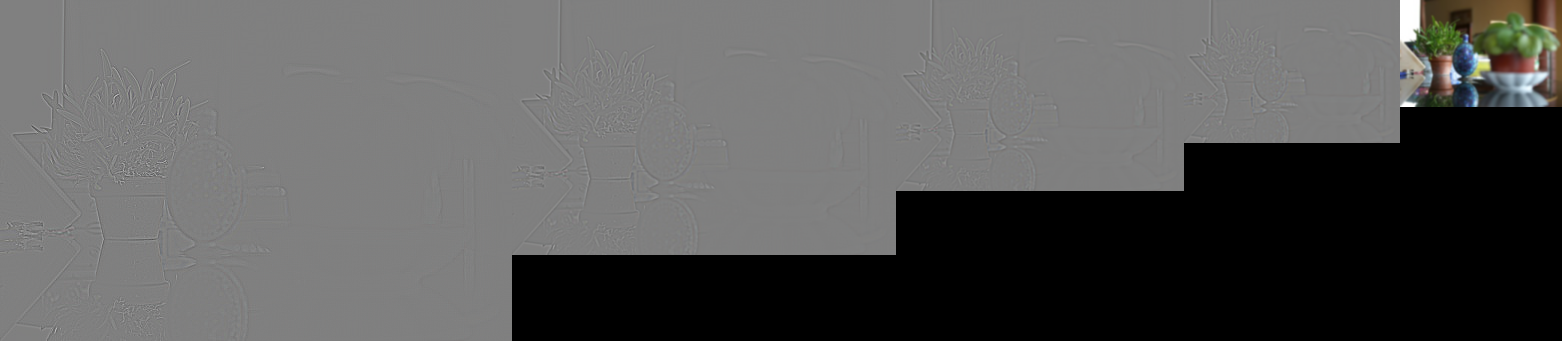

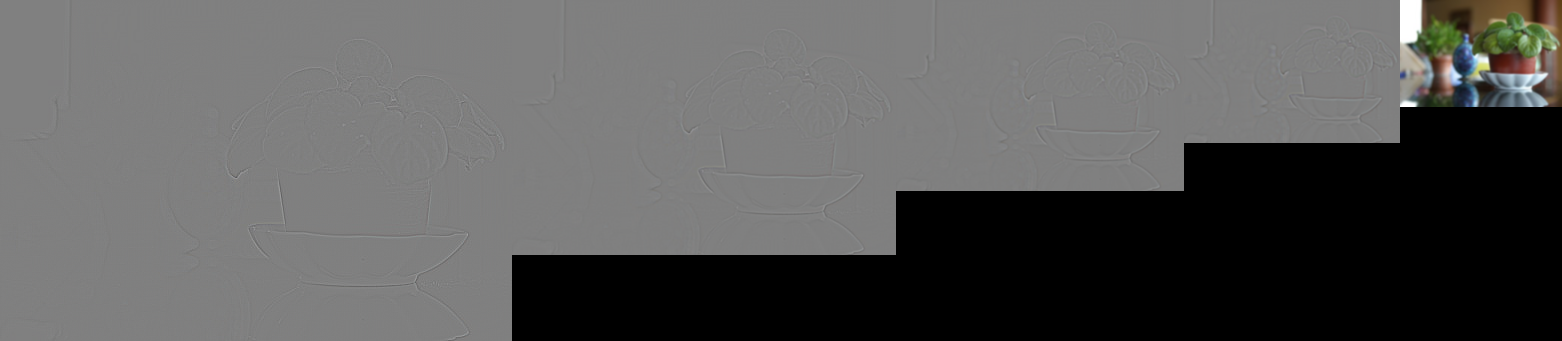

In [275]:
def ShowLaplacePyramid(pyramid: list[np.ndarray]): 
    width = 0
    height = 0
    for arr in pyramid: 
        img = Image.fromarray(arr.astype(np.uint8))
        width += img.size[0]
        height = max(height, img.size[1])
    result = Image.new('RGB', (width, height))
    x = 0
    for i in range(len(pyramid)-1): 
        img = Image.fromarray(np.clip((pyramid[i] + 128), 0, 255).astype(np.uint8))
        result.paste(img, (x, 0))
        x += img.size[0]
    img = Image.fromarray(pyramid[len(pyramid)-1].astype(np.uint8))
    result.paste(img, (x, 0))    
    display(result)
ShowLaplacePyramid(MakeLaplacianPyramid(np.asarray(Image.open('images/orchid.jpg'))))
ShowLaplacePyramid(MakeLaplacianPyramid(np.asarray(Image.open('images/violet.jpg'))))

In [260]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid: list[np.ndarray]) -> list[np.ndarray]: 
    gPyramid = []
    prev_arr = lPyramid[-1]
    # display(Image.fromarray(prev_arr.astype(np.uint8)))
    gPyramid.append(lPyramid[-1])
    for i in reversed(range(len(lPyramid)-1)): 
        prev_img = Image.fromarray(prev_arr.astype(np.uint8))
        prev_img = prev_img.resize((lPyramid[i].shape[1], lPyramid[i].shape[0]), Image.BICUBIC)
        prev_arr = np.asarray(prev_img).astype(np.float32)

        # display(prev_img)
        # display(Image.fromarray(lPyramid[i].astype(np.uint8)))

        prev_arr = np.clip(prev_arr + lPyramid[i], 0, 255)
        # print(prev_arr.dtype)
        # print(lPyramid[i].dtype)
        prev_img = Image.fromarray(prev_arr.astype(np.uint8))
        # display(prev_img)
        # print(prev_img.size)
        # print("Reconstructed")
        gPyramid.append(np.clip(prev_arr, 0, 255))   
    gPyramid.reverse()
    return gPyramid
# gPyramid = ReconstructGaussianFromLaplacianPyramid(MakeLaplacianPyramid(np.asarray(Image.open('images/orchid.jpg'))))
# for i in range(len(gPyramid)): 
#     display(Image.fromarray(gPyramid[i].astype(np.uint8)))

# display(Image.open('images/orchid.jpg'))
# print("Original")

C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1231856965.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), Image.BICUBIC)
C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1400926771.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  prev_img = prev_img.resize((lPyramid[i].shape[1], lPyramid[i].shape[0]), Image.BICUBIC)


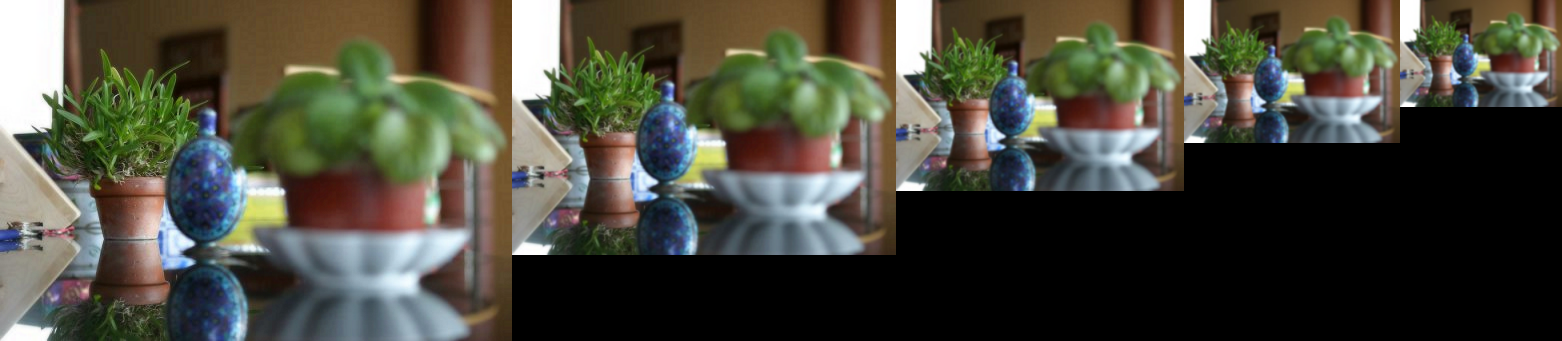

Reconstruction


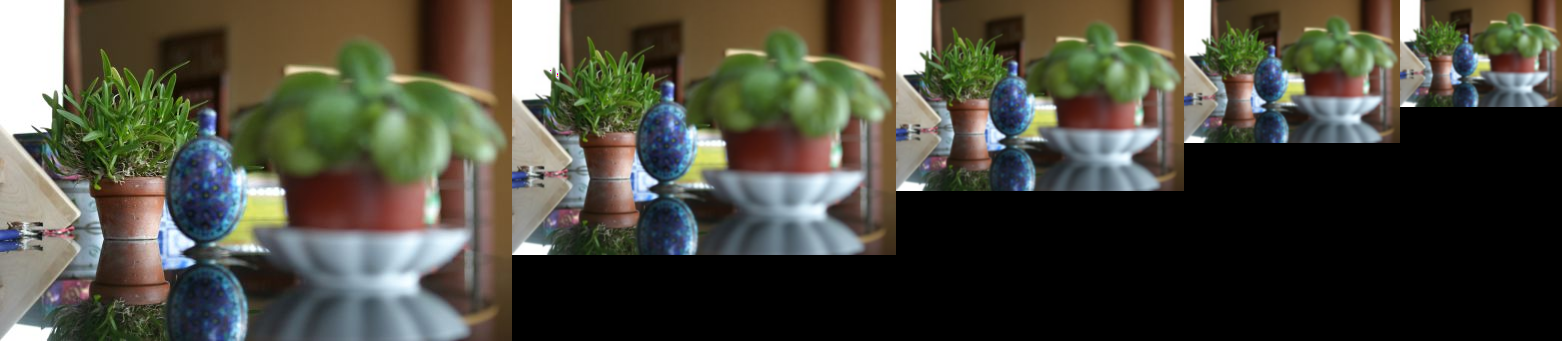

Original


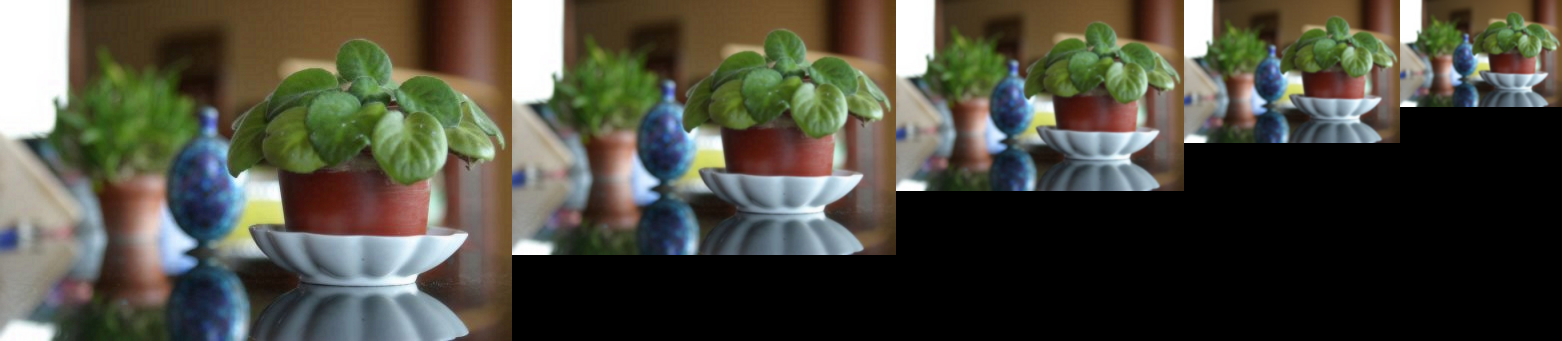

Reconstruction


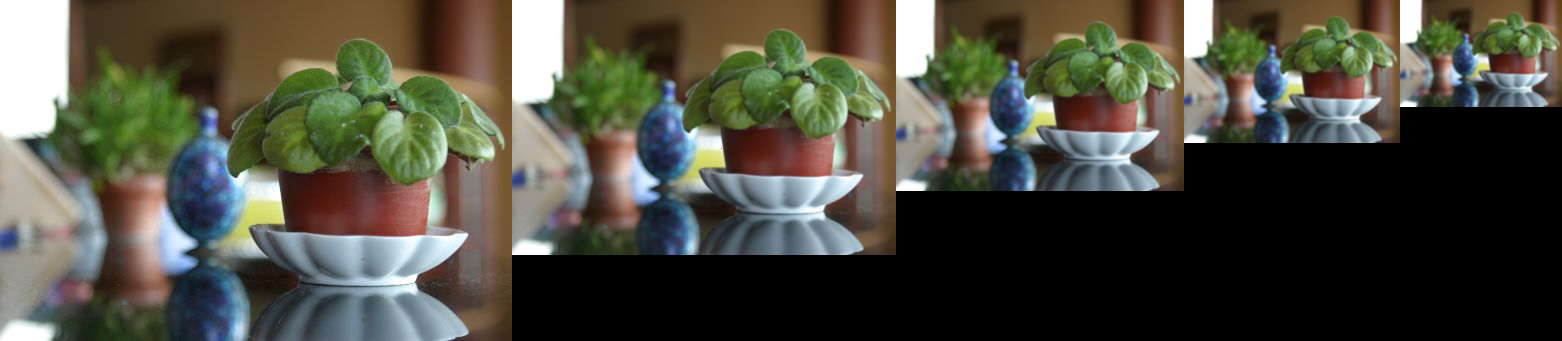

Original


In [268]:
ShowGaussianPyramid(ReconstructGaussianFromLaplacianPyramid(MakeLaplacianPyramid(np.asarray(Image.open('images/orchid.jpg')))))
print("Reconstruction")
# Since my MakeGaussianPyramid is for 1D, run it on all 3 channels of the original
arr3 = np.asarray(Image.open('images/orchid.jpg'))
gauss_pyramid_r = MakeGaussianPyramid(arr3[:,:,0])
gauss_pyramid_g = MakeGaussianPyramid(arr3[:,:,1])
gauss_pyramid_b = MakeGaussianPyramid(arr3[:,:,2])
gauss_pyramid_rgb = []
for i in range(len(gauss_pyramid_r)):
    gauss_pyramid_rgb.append(np.dstack((gauss_pyramid_r[i], gauss_pyramid_g[i], gauss_pyramid_b[i])))
ShowGaussianPyramid(gauss_pyramid_rgb)
print("Original")

ShowGaussianPyramid(ReconstructGaussianFromLaplacianPyramid(MakeLaplacianPyramid(np.asarray(Image.open('images/violet.jpg')))))
print("Reconstruction")
# Since my MakeGaussianPyramid is for 1D, run it on all 3 channels of the original
arr3 = np.asarray(Image.open('images/violet.jpg'))
gauss_pyramid_r = MakeGaussianPyramid(arr3[:,:,0])
gauss_pyramid_g = MakeGaussianPyramid(arr3[:,:,1])
gauss_pyramid_b = MakeGaussianPyramid(arr3[:,:,2])
gauss_pyramid_rgb = []
for i in range(len(gauss_pyramid_r)):
    gauss_pyramid_rgb.append(np.dstack((gauss_pyramid_r[i], gauss_pyramid_g[i], gauss_pyramid_b[i])))
ShowGaussianPyramid(gauss_pyramid_rgb)
print("Original")

C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1231856965.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), Image.BICUBIC)


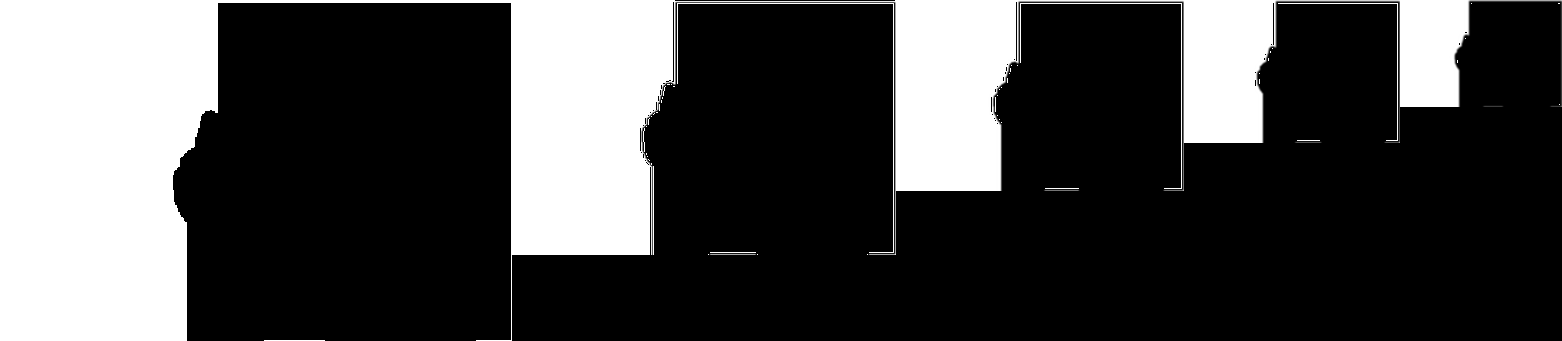

In [265]:
gaussianM = MakeGaussianPyramid(np.asarray(Image.open('images/orchid_mask.bmp')))
ShowGaussianPyramid(gaussianM)

C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1231856965.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((int(img.size[0]*scale), int(img.size[1]*scale)), Image.BICUBIC)
C:\Users\kerry\AppData\Local\Temp\ipykernel_8456\1400926771.py:8: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  prev_img = prev_img.resize((lPyramid[i].shape[1], lPyramid[i].shape[0]), Image.BICUBIC)


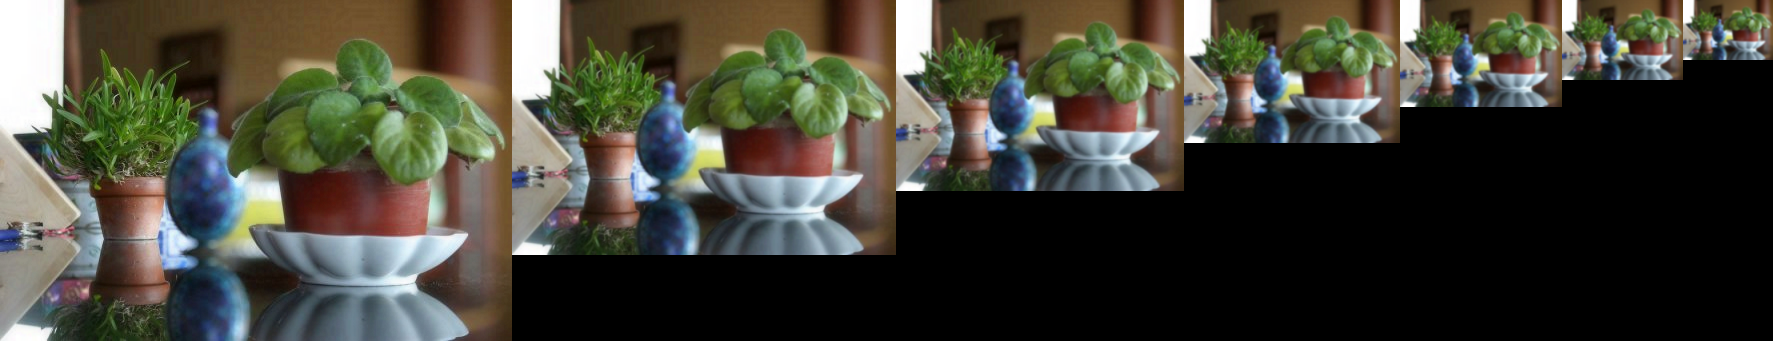

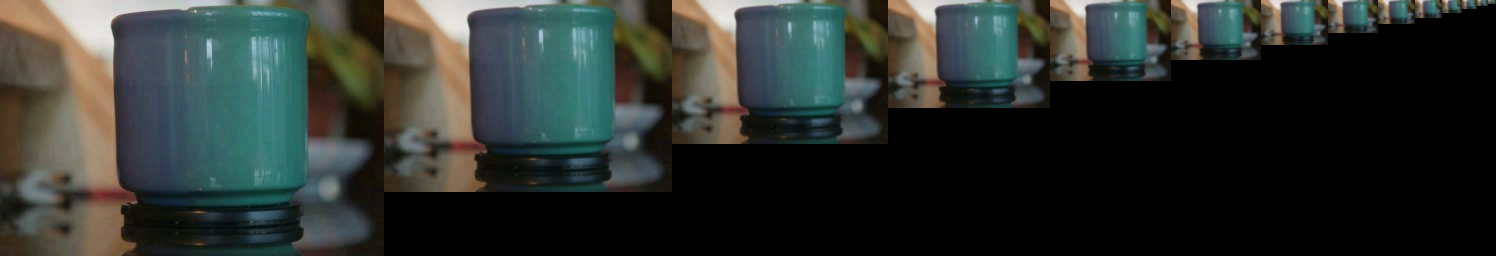

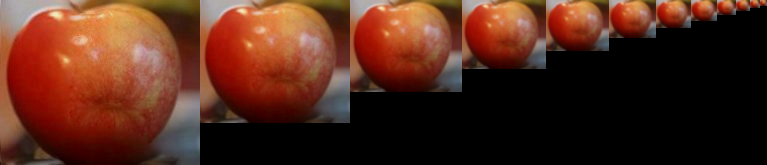

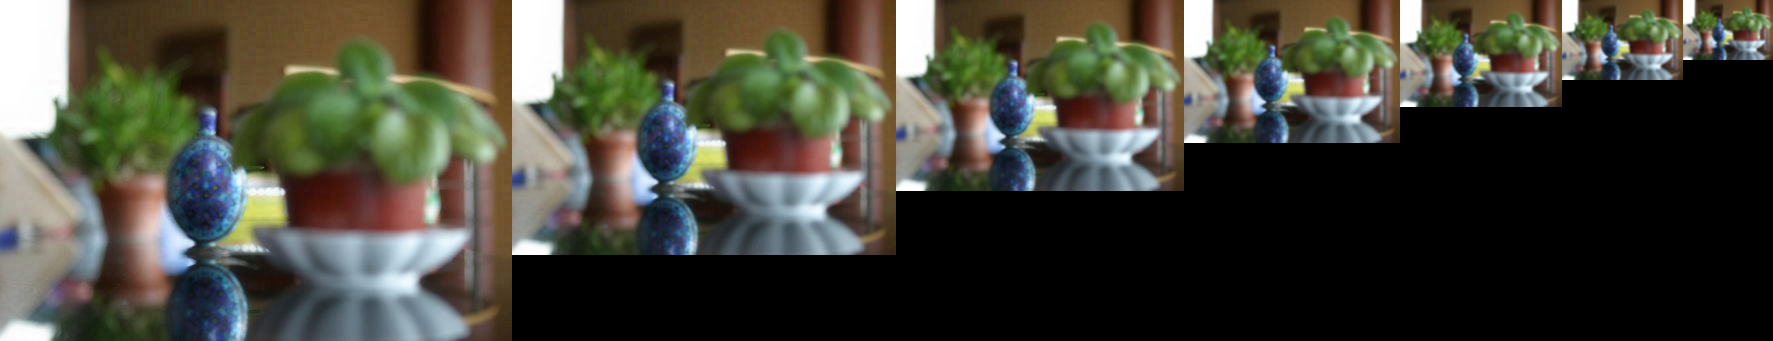

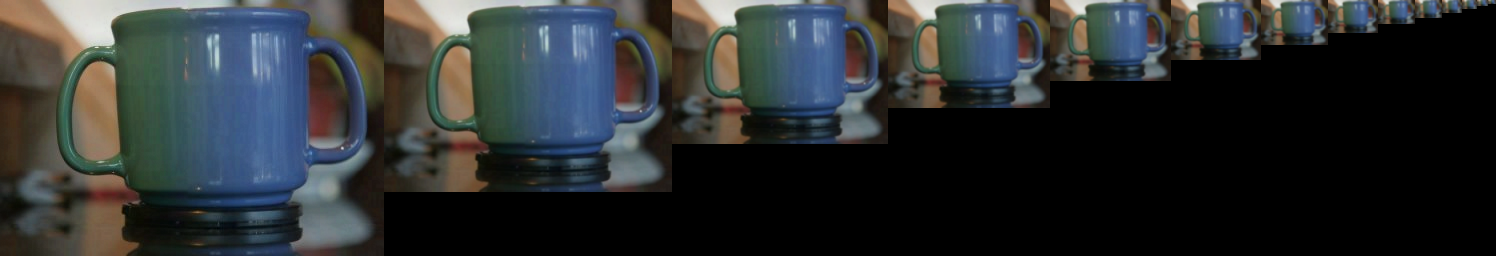

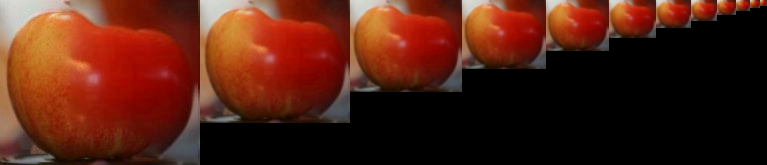

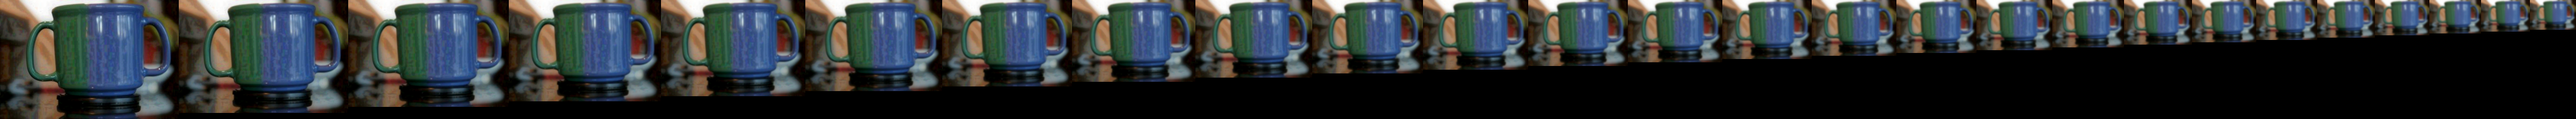

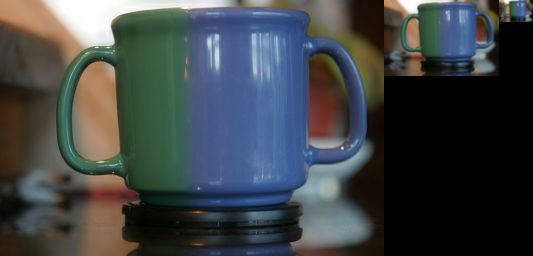

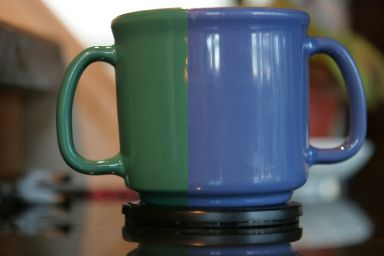

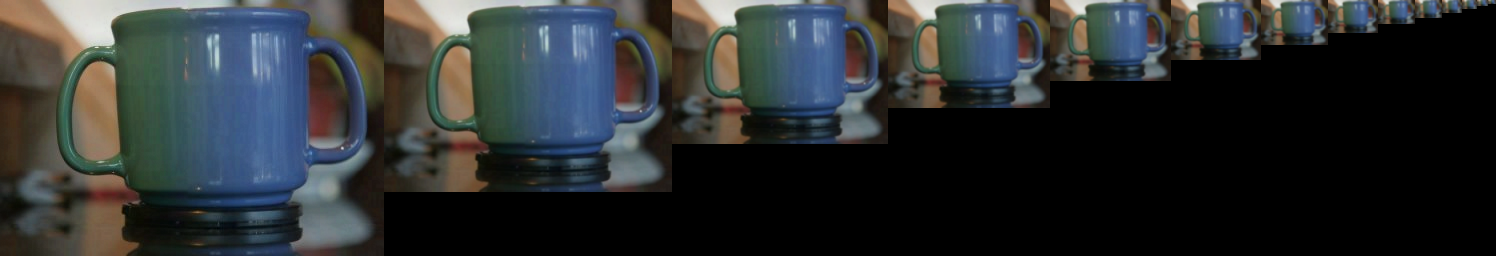

In [311]:
def PyramidBlend(lPyramid1: list[np.ndarray], lPyramid2: list[np.ndarray], gPyramidMask: list[np.ndarray], scale: float=0.75, minsize: float=200) -> None:
    lapA = MakeLaplacianPyramid(lPyramid1, scale, minsize)
    lapB = MakeLaplacianPyramid(lPyramid2, scale, minsize)
    # Change mask to 3 channels
    mask_3 = gPyramidMask
    mask_r = MakeGaussianPyramid(mask_3[:,:], scale, minsize)
    mask_g = MakeGaussianPyramid(mask_3[:,:], scale, minsize)
    mask_b = MakeGaussianPyramid(mask_3[:,:], scale, minsize)
    gaussianM = []
    for i in range(len(mask_r)):
        gaussianM.append(np.dstack((mask_r[i], mask_g[i], mask_b[i])))

    compLaplacian = [None] * len(lapA)
    for i in range(len(lapA)): 
        # display(Image.fromarray(lapA[i].astype(np.uint8)))
        # display(Image.fromarray((gaussianM[i]).astype(np.uint8)))
        # display(Image.fromarray(lapB[i].astype(np.uint8)))
        # display(Image.fromarray(((1 - gaussianM[i]/255) * 255).astype(np.uint8)))
        # display(Image.fromarray((lapA[i] * gaussianM[i]/255 +  lapB[i] * (1 - gaussianM[i]/255)).astype(np.uint8)))

        compLaplacian[i] = lapA[i] * gaussianM[i]/255 +  lapB[i] * (1 - gaussianM[i]/255)
    ShowGaussianPyramid(ReconstructGaussianFromLaplacianPyramid(compLaplacian))
PyramidBlend(np.asarray(Image.open('images/orchid.jpg')), np.asarray(Image.open('images/violet.jpg')), np.asarray(Image.open('images/orchid_mask.bmp')), 0.75, 100)
PyramidBlend(np.asarray(Image.open('images/blue_cup.jpg')), np.asarray(Image.open('images/green_cup.jpg')), np.asarray(Image.open('images/cup_mask.bmp')), 0.75, 10)
PyramidBlend(np.asarray(Image.open('images/tomato.jpg')), np.asarray(Image.open('images/apple.jpg')), np.asarray(Image.open('images/tomato_mask.bmp')), 0.75, 10)

PyramidBlend(np.asarray(Image.open('images/violet.jpg')), np.asarray(Image.open('images/orchid.jpg')), np.asarray(Image.open('images/orchid_mask.bmp')), 0.75, 100)
PyramidBlend(np.asarray(Image.open('images/green_cup.jpg')), np.asarray(Image.open('images/blue_cup.jpg')), np.asarray(Image.open('images/cup_mask.bmp')), 0.75, 10)
PyramidBlend(np.asarray(Image.open('images/apple.jpg')), np.asarray(Image.open('images/tomato.jpg')), np.asarray(Image.open('images/tomato_mask.bmp')), 0.75, 10)

# Pretty interesting playing around with parameters. 
# Increasing the scale means more and more one image appears on the other image. 
# Decreasing the minsize means there is more blending. 
PyramidBlend(np.asarray(Image.open('images/green_cup.jpg')), np.asarray(Image.open('images/blue_cup.jpg')), np.asarray(Image.open('images/cup_mask.bmp')), 0.95, 100)
PyramidBlend(np.asarray(Image.open('images/green_cup.jpg')), np.asarray(Image.open('images/blue_cup.jpg')), np.asarray(Image.open('images/cup_mask.bmp')), 0.3, 100)
PyramidBlend(np.asarray(Image.open('images/green_cup.jpg')), np.asarray(Image.open('images/blue_cup.jpg')), np.asarray(Image.open('images/cup_mask.bmp')), 0.75, 1000)
PyramidBlend(np.asarray(Image.open('images/green_cup.jpg')), np.asarray(Image.open('images/blue_cup.jpg')), np.asarray(Image.open('images/cup_mask.bmp')), 0.75, 10)
